In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../')

import copy
import itertools
import random
import time

import gensim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
from scipy.sparse import csgraph
from scipy.stats import bayes_mvs
from scipy.stats import ttest_ind
import pandas as pd

import networkx as nx

from joblib import Parallel, delayed

import sampl.gsn_api as gsn
import sampl.semantics as sem
import sampl.update as update
import sampl.agent as agent
import sampl.paradigm_coman as coman

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
costs = np.load(file='../grid_search_results/costs_coman_2019-04-15.npy')

In [7]:
def plot_results_no_compare(results):
    sns.set_style('ticks')
    print("Calculating convergence...")
    co_df = coman.convergence_df(results, add_source=True)
    print("Calculating alignment...")
    al_df = coman.alignment_df(results, add_source=True)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
    sns.barplot(data=co_df[co_df['Condition'] == 'Clustered'], x='Time', y='Convergence', hue='Source', ax=ax1)
    sns.barplot(data=co_df[co_df['Condition'] == 'Non-clustered'], x='Time', y='Convergence', hue='Source', ax=ax2)
    ax1.set_title("Clustered")
    ax2.set_title("Non-clustered")

    sns.barplot(data=al_df[al_df['Condition'] == 'Clustered'], x='Hops', y='Alignment', hue='Source', ax=ax3)
    sns.barplot(data=al_df[al_df['Condition'] == 'Non-clustered'], x='Hops', y='Alignment', hue='Source', ax=ax4)

    sns.despine()    
    plt.tight_layout()

In [8]:
def plot_results(results, plot_cmdg=True, sim_title="Simulation", title=None):
    sns.set(font_scale=1.6)
    sns.set_style('ticks')
    print("Calculating convergence...")
    co_df = coman.convergence_df(results, add_source=True)
    print("Calculating alignment...")
    al_df = coman.alignment_df(results, add_source=True)
    
    co_df_t = co_df[co_df['Source'] == 'CMDG 2016']
    co_df_s = co_df[co_df['Source'] == 'Simulation']
    
    al_df_t = al_df[al_df['Source'] == 'CMDG 2016']
    al_df_s = al_df[al_df['Source'] == 'Simulation']
    
    c_sim = sns.color_palette()[0]
    c_tar = sns.color_palette()[1]

    if plot_cmdg:
        fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12, 6))
    else:
        fig, ((ax1, ax2), (ax5, ax6)) = plt.subplots(2, 2, figsize=(6, 6))

    sns.barplot(data=co_df_s[co_df_s['Condition'] == 'Clustered'], x='Time', y='Convergence', order=['Before', 'After'], color=c_sim, ax=ax1)
    sns.barplot(data=co_df_s[co_df_s['Condition'] == 'Non-clustered'], x='Time', y='Convergence', order=['Before', 'After'], color=c_sim, ax=ax2)
    if plot_cmdg:
        sns.barplot(data=co_df_t[co_df_t['Condition'] == 'Clustered'], x='Time', y='Convergence', order=['Before', 'After'], color=c_tar, ax=ax3)
        sns.barplot(data=co_df_t[co_df_t['Condition'] == 'Non-clustered'], x='Time', y='Convergence', order=['Before', 'After'], color=c_tar, ax=ax4)

    sns.barplot(data=al_df_s[al_df_s['Condition'] == 'Clustered'], x='Hops', y='Alignment', color=c_sim, ax=ax5)
    sns.barplot(data=al_df_s[al_df_s['Condition'] == 'Non-clustered'], x='Hops', y='Alignment', color=c_sim, ax=ax6)
    if plot_cmdg:
        sns.barplot(data=al_df_t[al_df_t['Condition'] == 'Clustered'], x='Hops', y='Alignment', color=c_tar, ax=ax7)
        sns.barplot(data=al_df_t[al_df_t['Condition'] == 'Non-clustered'], x='Hops', y='Alignment', color=c_tar, ax=ax8)
    
    if plot_cmdg:
        for ax in [ax5, ax6, ax7, ax8]:
            ax.set_xlabel('Distance')
    else:
        for ax in [ax5, ax6]:
            ax.set_xlabel('Distance')
    
    ax1.set_title(f"{sim_title}\nClustered")
    ax2.set_title(f"{sim_title}\nNon-clustered")
    if plot_cmdg:
        ax3.set_title("CMDG 2016\nClustered")
        ax4.set_title("CMDG 2016\nNon-clustered")
    ax5.set_title(f"{sim_title}\nClustered")
    ax6.set_title(f"{sim_title}\nNon-clustered")
    if plot_cmdg:
        ax7.set_title("CMDG 2016\nClustered")
        ax8.set_title("CMDG 2016\nNon-clustered")
    
    if title is not None:
        fig.suptitle(title)

    sns.despine()    
    plt.tight_layout()
    
def plot_func(op_win, ax=None):
    xs = np.linspace(0, 1., 101)
    ys = op_win.update_fx(xs)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(xs, ys)
    ax.set_xlabel('Activation strength')
    ax.set_ylabel('Weight change')
    ax.set_title('Non-monotonic plasticity function')
    #ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1] + .1))
    ylim = ax.get_ylim()
    one_percent_y = (ylim[1] - ylim[0]) / 100
    ax.text(x=0, y=ylim[1] - one_percent_y * 10, s=f"γ (discount) = {str(round(op_win.discount, 2))}")

    sns.despine()    
    plt.tight_layout()

In [9]:
i = np.argsort(costs[:, 6])[0]
params_win = costs[i, 0:6]
y_min, y_max, dip_center, dip_width, discount, learning_rate = costs[i, 0:6].astype(np.float64).round(2)

In [10]:
print(y_min, y_max, dip_center, dip_width, discount, learning_rate)

-0.8 0.5 0.3 0.4 0.5 1.0


In [11]:
result_win = coman.run_with_params(params_win, n_runs=80)

In [12]:
cost_win = coman.cost(result_win)[0]
cost_win

0.17023571639647003

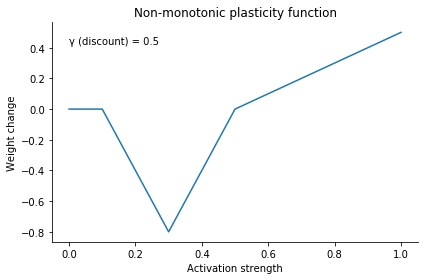

In [13]:
#fig, ax = plt.subplots(figsize=(4,4))
plot_func(result_win[0]['agents_clustered_before'][0].op)

Calculating convergence...
Calculating alignment...


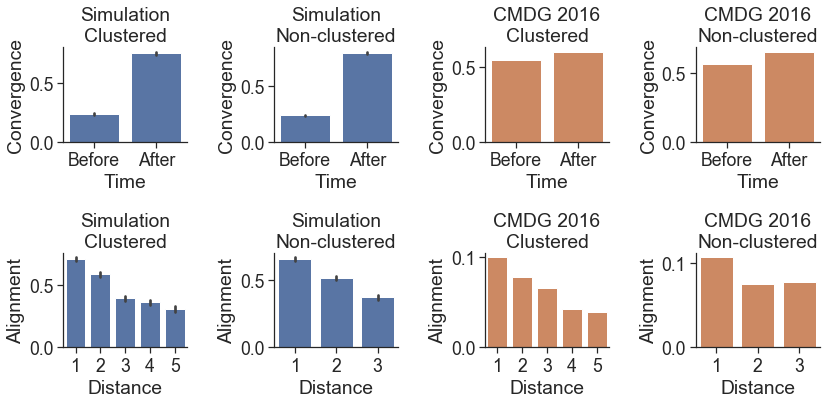

In [14]:
plot_results(result_win)

In [15]:
print("Calculating convergence...")
co_df = coman.convergence_df(result_win, add_source=True)
print("Calculating alignment...")
al_df = coman.alignment_df(result_win, add_source=True)

co_df_t = co_df[co_df['Source'] == 'CMDG 2016']
co_df_s = co_df[co_df['Source'] == 'Simulation']

al_df_t = al_df[al_df['Source'] == 'CMDG 2016']
al_df_s = al_df[al_df['Source'] == 'Simulation']

Calculating convergence...
Calculating alignment...


In [16]:
co_df_t.head()

,Convergence,Time,Condition,Source
320,0.660,After,Non-clustered,CMDG 2016
321,0.570,Before,Non-clustered,CMDG 2016
322,0.606,After,Clustered,CMDG 2016
323,0.546,Before,Clustered,CMDG 2016


In [17]:
cl_after = co_df_s[(co_df_s['Time'] == 'After') & (co_df_s['Condition'] == 'Clustered')]['Convergence'].values
cl_before = co_df_s[(co_df_s['Time'] == 'Before') & (co_df_s['Condition'] == 'Clustered')]['Convergence'].values
ncl_after = co_df_s[(co_df_s['Time'] == 'After') & (co_df_s['Condition'] == 'Non-clustered')]['Convergence'].values
ncl_before = co_df_s[(co_df_s['Time'] == 'Before') & (co_df_s['Condition'] == 'Non-clustered')]['Convergence'].values

In [18]:
bayes_mvs(cl_after)[0]

Mean(statistic=0.7606879709208455, minmax=(0.7492020852770511, 0.7721738565646399))

In [19]:
bayes_mvs(cl_before)[0]

Mean(statistic=0.2344904504112384, minmax=(0.2279876357321024, 0.2409932650903744))

In [20]:
bayes_mvs(ncl_after)[0]

Mean(statistic=0.796431914241764, minmax=(0.7872978461953194, 0.8055659822882085))

In [21]:
bayes_mvs(ncl_before)[0]

Mean(statistic=0.2344904504112384, minmax=(0.2279876357321024, 0.2409932650903744))

In [22]:
ttest_ind(
    cl_after,
    cl_before,
    equal_var=False
)

Ttest_indResult(statistic=66.35288364007371, pvalue=2.9199446532575914e-99)

In [23]:
ttest_ind(
    ncl_after,
    ncl_before,
    equal_var=False
)

Ttest_indResult(statistic=83.41476732989777, pvalue=5.587319439141964e-123)

In [24]:
dof = (
    len(cl_after) + 
    len(cl_before) - 2
)
dof

158

In [25]:
dof = (
    len(ncl_after) + 
    len(ncl_before) - 2
)
dof

158

In [26]:
ttest_ind(
    ncl_after,
    cl_after,
    equal_var=False
)

Ttest_indResult(statistic=4.053903878908478, pvalue=8.055236643875298e-05)

In [27]:
import statsmodels.api as sm

In [28]:
al_df_s.head()

,Alignment,Hops,Condition,Source
0,0.766129,1,Clustered,Simulation
1,0.149820,1,Clustered,Simulation
2,0.972316,1,Clustered,Simulation
3,0.716939,2,Clustered,Simulation
4,0.401156,3,Clustered,Simulation


In [29]:
al_clust = al_df_s[al_df_s['Condition'] == 'Clustered']
al_nclust = al_df_s[al_df_s['Condition'] == 'Non-clustered']

In [30]:
X = sm.add_constant(al_clust['Hops'].values.reshape(-1, 1))
y = al_clust['Alignment'].values
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     1258.
Date:                Mon, 23 Sep 2019   Prob (F-statistic):          1.51e-236
Time:                        15:19:45   Log-Likelihood:                -174.73
No. Observations:                3600   AIC:                             353.5
Df Residuals:                    3598   BIC:                             365.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8020      0.009     90.576      0.000       0.785       0.819
x1            -0.1118      0.003    -35.466      0.000      -0.118      -0.106
==============================================================================
Omnibus:                      122.751   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.801
Skew:                          -0.471   Prob(JB):                     5.35e-30
Kurtosis:                       3.099   Cond. No.                         6.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
X = sm.add_constant(al_nclust['Hops'].values.reshape(-1, 1))
y = al_nclust['Alignment'].values
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     504.7
Date:                Mon, 23 Sep 2019   Prob (F-statistic):          1.03e-104
Time:                        15:19:52   Log-Likelihood:                -478.08
No. Observations:                3600   AIC:                             960.2
Df Residuals:                    3598   BIC:                             972.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7915      0.013     62.449      0.000       0.767       0.816
x1            -0.1404      0.006    -22.466      0.000      -0.153      -0.128
==============================================================================
Omnibus:                       98.052   Durbin-Watson:                   1.574
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.761
Skew:                          -0.419   Prob(JB):                     1.08e-23
Kurtosis:                       2.936   Cond. No.                         6.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
n_runs = 40

y_min_param_sets = []
y_min_unique = np.linspace(-1, 0, 11).round(2)
for v in y_min_unique:
    y_min_param_sets.append(
        (v, y_max, dip_center, dip_width, discount, learning_rate)
    )
y_min_results = [coman.run_with_params(p, n_runs=n_runs) for p in y_min_param_sets]
y_min_costs = np.array([coman.cost(r)[0] for r in y_min_results])
    
y_max_param_sets = []
y_max_unique = np.linspace(0, 1, 11).round(2)
for v in y_max_unique:
    y_max_param_sets.append(
        (y_min, v, dip_center, dip_width, discount, learning_rate)
    )
y_max_results = [coman.run_with_params(p, n_runs=n_runs) for p in y_max_param_sets]
y_max_costs = np.array([coman.cost(r)[0] for r in y_max_results])

discount_param_sets = []
discount_unique = np.linspace(0, 1, 11).round(2)
for v in discount_unique:
    discount_param_sets.append(
        (y_min, y_max, dip_center, dip_width, v, learning_rate)
    )
discount_results = [coman.run_with_params(p, n_runs=n_runs) for p in discount_param_sets]
discount_costs = np.array([coman.cost(r)[0] for r in discount_results])

learning_rate_param_sets = []
learning_rate_unique = np.linspace(0, 1, 11).round(2)
for v in learning_rate_unique:
    learning_rate_param_sets.append(
        (y_min, y_max, dip_center, dip_width, discount, v)
    )
learning_rate_results = [coman.run_with_params(p, n_runs=n_runs) for p in learning_rate_param_sets]
learning_rate_costs = np.array([coman.cost(r)[0] for r in learning_rate_results])

/Users/beau/miniconda3/envs/latest/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
../sampl/paradigm_coman.py:404: RuntimeWarning: invalid value encountered in true_divide
  alignment_values_p = alignment_values / alignment_values[0]


In [36]:
# Remove duplicate x and y values that result from overlap between the
# grid search and the block above. This is because the results might differ
# between the grid search and the block because of noise. For clarity we only
# want to report the grid search value

y_min_costs[y_min_unique == y_min] = cost_win
y_max_costs[y_max_unique == y_max] = cost_win
discount_costs[discount_unique == discount] = cost_win
learning_rate_costs[learning_rate_unique == learning_rate] = cost_win

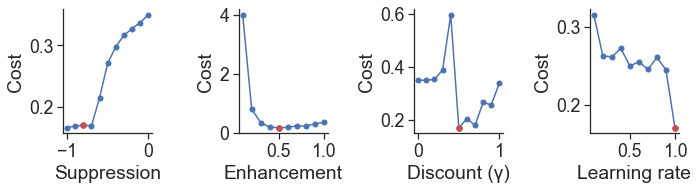

In [38]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 3))
msize=5
ax1.plot(y_min_unique, y_min_costs, 'o-', markersize=msize, color=sns.color_palette()[0])
ax1.plot(y_min, cost_win, 'o', markersize=msize+.5, color=sns.color_palette()[3])
ax1.set_xlabel('Suppression')
ax1.set_ylabel('Cost')

ax2.plot(y_max_unique, y_max_costs, 'o-', markersize=msize, color=sns.color_palette()[0])
ax2.plot(y_max, cost_win, 'o', markersize=msize+.5, color=sns.color_palette()[3])
ax2.set_xlabel('Enhancement')
ax2.set_ylabel('Cost')

ax3.plot(discount_unique, discount_costs, 'o-', markersize=msize, color=sns.color_palette()[0])
ax3.plot(discount, cost_win, 'o', markersize=msize+.5, color=sns.color_palette()[3])
ax3.set_xlabel('Discount (γ)')
ax3.set_ylabel('Cost')

ax4.plot(learning_rate_unique, learning_rate_costs, 'o-', markersize=msize, color=sns.color_palette()[0])
ax4.plot(learning_rate, cost_win, 'o', markersize=msize+.5, color=sns.color_palette()[3])
ax4.set_xlabel('Learning rate')
ax4.set_ylabel('Cost')

plt.tight_layout()
sns.despine()

## Lesion analysis

In [39]:
params_lesion = copy.copy(params_win)
params_lesion[0] = 0
res_lesion = coman.run_with_params(params_lesion, n_runs=80)

In [40]:
print("Calculating convergence...")
co_les_df = coman.convergence_df(res_lesion, add_source=True)
print("Calculating alignment...")
al_les_df = coman.alignment_df(res_lesion, add_source=True)

co_les_t = co_les_df[co_les_df['Source'] == 'CMDG 2016']
co_les_s = co_les_df[co_les_df['Source'] == 'Simulation']

al_les_t = al_les_df[al_les_df['Source'] == 'CMDG 2016']
al_les_s = al_les_df[al_les_df['Source'] == 'Simulation']

Calculating convergence...
Calculating alignment...


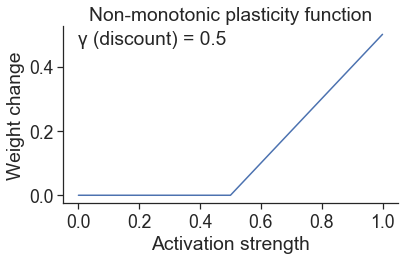

In [41]:
plot_func(res_lesion[0]['agents_clustered_before'][0].op)

Calculating convergence...
Calculating alignment...


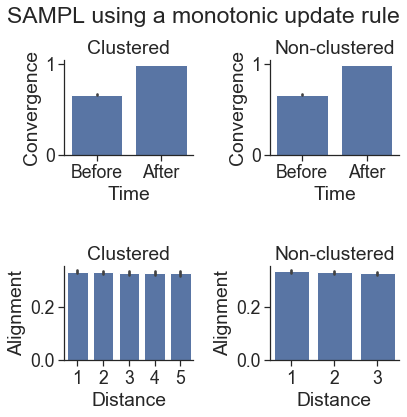

In [42]:
plot_results(res_lesion, plot_cmdg=False, sim_title="", title="SAMPL using a monotonic update rule")

In [43]:
cl_les_after = co_les_s[(co_les_s['Time'] == 'After') & (co_les_s['Condition'] == 'Clustered')]['Convergence'].values
cl_les_before = co_les_s[(co_les_s['Time'] == 'Before') & (co_les_s['Condition'] == 'Clustered')]['Convergence'].values
ncl_les_after = co_les_s[(co_les_s['Time'] == 'After') & (co_les_s['Condition'] == 'Non-clustered')]['Convergence'].values
ncl_les_before = co_les_s[(co_les_s['Time'] == 'Before') & (co_les_s['Condition'] == 'Non-clustered')]['Convergence'].values

In [44]:
ttest_ind(
    ncl_les_after,
    cl_les_after,
    equal_var=False
)

Ttest_indResult(statistic=0.37121869527505263, pvalue=0.7109859615528624)

In [45]:
al_les_clust = al_les_s[al_les_s['Condition'] == 'Clustered']
al_les_nclust = al_les_s[al_les_s['Condition'] == 'Non-clustered']

In [46]:
X = sm.add_constant(al_les_clust['Hops'].values.reshape(-1, 1))
y = al_les_clust['Alignment'].values
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.188
Date:                Mon, 23 Sep 2019   Prob (F-statistic):              0.139
Time:                        15:49:18   Log-Likelihood:                 3687.0
No. Observations:                3600   AIC:                            -7370.
Df Residuals:                    3598   BIC:                            -7358.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3349      0.003    110.581      0.000       0.329       0.341
x1            -0.0016      0.001     -1.479      0.139      -0.004       0.001
==============================================================================
Omnibus:                       48.579   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.771
Skew:                          -0.204   Prob(JB):                     8.50e-10
Kurtosis:                       2.665   Cond. No.                         6.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
X = sm.add_constant(al_les_nclust['Hops'].values.reshape(-1, 1))
y = al_les_nclust['Alignment'].values
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.375
Date:                Mon, 23 Sep 2019   Prob (F-statistic):             0.0663
Time:                        15:49:18   Log-Likelihood:                 3687.6
No. Observations:                3600   AIC:                            -7371.
Df Residuals:                    3598   BIC:                            -7359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3378      0.004     84.784      0.000       0.330       0.346
x1            -0.0036      0.002     -1.837      0.066      -0.007       0.000
==============================================================================
Omnibus:                       48.865   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.852
Skew:                          -0.203   Prob(JB):                     8.16e-10
Kurtosis:                       2.663   Cond. No.                         6.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""